# CNNs

#### Loading the mnist dataset
With the purpose of distinguishing 3s from 7s

In [6]:
from fastai.vision.all import *
import matplotlib
matplotlib.rc('image', cmap='Greys')

path = untar_data(URLs.MNIST_SAMPLE)

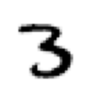

In [7]:
Path.BASE_PATH = path
im3 = Image.open(path/'train'/'3'/'12.png')
show_image(im3);

In [8]:
im3.shape

(28, 28)

In [9]:
#Creating a dataloader
mnist = DataBlock(blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
                get_items = get_image_files,
                splitter = GrandparentSplitter(),
                get_y = parent_label)

dls = mnist.dataloaders(path)
xb, yb = first(dls.valid)
xb.shape

torch.Size([64, 1, 28, 28])

One batch contains 64 images, each of 1 channel, with 28×28 pixels

A *channel* is a single basic color in an image—for regular full-color images there are three channels, red, green, and blue. PyTorch represents an image as a rank-3 tensor, with dimensions `[channels, rows, columns]`.

In [10]:
# By default, fastai puts data on the GPU - but I don't have any :-)
xb,yb = to_cpu(xb),to_cpu(yb)

#### Basic neural net

In [11]:
import torch
from torch import nn
import torch.nn.functional as F

simple_nn = nn.Sequential(
    nn.Linear(28*28, 30),
    nn.ReLU(),
    nn.Linear(30, 1)
)

In [12]:
simple_nn

Sequential(
  (0): Linear(in_features=784, out_features=30, bias=True)
  (1): ReLU()
  (2): Linear(in_features=30, out_features=1, bias=True)
)

### CNN
Using **nn.Conv2d(in_channels, out_channels, kernel_size, more..)** instead of F.conv2d because the module automatically initializes the weights and biases (alternatively we would have to define them ourselves and pass them as arguments to F.conv2d)

The parameters kernel_size, stride, padding, dilation can either be:
- a single int – in which case the same value is used for the height and width dimension
- a tuple of two ints – in which case, the first int is used for the height dimension, and the second int for the width dimension

**Out channels:**

The number of output channels, **also called features, is the number of filters that will be applied to the input image**. Each filter is a different set of weights and biases that will be learned by the CNN. The more filters we have, the more patterns we can detect, but the more computationally expensive our model will be.

In [13]:
broken_cnn = nn.Sequential(
    #in_channels = 1, out_channels = 30, kernel size = 3x3
    #padding = 1 means that the output will be the same size as the input
    nn.Conv2d(1,30, kernel_size=3,padding=1),
    nn.ReLU(),
    #in_channels = 30, out_channels = 1, kernel size = 3x3
    nn.Conv2d(30,1, kernel_size=3,padding=1)
)

One thing to note here is that we didn't need to specify 28×28 as the input size. That's because a linear layer needs a weight in the weight matrix for every pixel, so it needs to know how many pixels there are, but a convolution is applied over each pixel automatically. The weights only depend on the number of input and output channels and the kernel size, as we saw in the previous section.

In [14]:
broken_cnn(xb).shape

torch.Size([64, 1, 28, 28])

The output cannot be used for classification as we have 28 x 28 map of activations. One way to deal with this, is to add enough stride-2 convolutions (halves the size of the image) to reduce the size of the final map to 1 x 1. 

In [15]:
#Define a function to create each convolutional layer

def conv(n_inputs, n_features, ks=3, activation=True):
    res = nn.Conv2d(n_inputs, n_features, stride=2, kernel_size=ks, padding=ks//2)
    if activation: 
        res = nn.Sequential(res, nn.ReLU())
    return res

In [16]:
#Due to stride=2 the image size is reduced by half in each layer (rounded up if uneven)
#At the same time, we increase the number of features (channels) by a factor of 2 to compensate for the loss of information

simple_cnn = nn.Sequential(
    conv(1, 4),            #14x14
    conv(4, 8),            #7x7
    conv(8, 16),           #4x4
    conv(16, 32),          #2x2
    conv(32, 2, activation=False), #1x1
    nn.Flatten(),
)

In [17]:
simple_cnn(xb).shape

torch.Size([64, 2])

After which the learner can now be created

In [18]:
learn = Learner(dls, simple_cnn, loss_func=F.cross_entropy, metrics=accuracy)
learn.summary()

Sequential (Input shape: 64 x 1 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 4 x 14 x 14    
Conv2d                                    40         True      
ReLU                                                           
____________________________________________________________________________
                     64 x 8 x 7 x 7      
Conv2d                                    296        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 16 x 4 x 4     
Conv2d                                    1168       True      
ReLU                                                           
____________________________________________________________________________
                     64 x 32 x 2 x 2     
Conv2d                                    4640       True      
ReLU                                          

As seen in the summary, the first layer has dim 64x1x28x28, the axis are batch_size, channels, height, width - often written NCHW (in tensorflow written NHWC).

In [19]:
learn.fit_one_cycle(2,0.01)
# https://iconof.com/1cycle-learning-rate-policy/

epoch,train_loss,valid_loss,accuracy,time
0,0.062782,0.041600,0.988714,00:06
1,0.022793,0.028037,0.991659,00:05


First convolutional layer:

In [20]:
m = learn.model[0]
m

Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
)


PyTorch has it built in. It's called `F.conv2d` (recall that `F` is a fastai import from `torch.nn.functional`, as recommended by PyTorch). The PyTorch docs tell us that it includes these parameters:

- input:: input tensor of shape `(minibatch, in_channels, iH, iW)`
- weight:: filters of shape `(out_channels, in_channels, kH, kW)`

Here `iH,iW` is the height and width of the image (i.e., `28,28`), and `kH,kW` is the height and width of our kernel (`3,3`). But apparently PyTorch is expecting rank-4 tensors for both these arguments, whereas currently we only have rank-2 tensors (i.e., matrices, or arrays with two axes).

Kernels passed to `F.conv2d` need to be rank-4 tensors: `[channels_in, features_out, rows, columns]` , where channels_in is the number of input channels, and features_out is the number of output channels.